In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import os

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Pré-Processamento
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline

# Oversampling e Undersampling
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Métricas
from sklearn.metrics import confusion_matrix, make_scorer, roc_curve, roc_auc_score, ConfusionMatrixDisplay

In [2]:
warnings.filterwarnings('ignore')

Importando meus dados modificados

In [3]:
PATH_MODIFIED = os.path.join("..", "Data", "modified_data.csv")
data = pd.read_csv(PATH_MODIFIED)

In [4]:
target_feature = ["Personal Loan"]
id_features = ["ID", "ZIP Code"]
numeric_features = ["Age", "Income", "CCAvg"]
categorical_features = ["Family", "Education", "Securities Account", "CD Account", "Online", "CreditCard"]

## Avaliação do negócio

Relembrando nosso problema de negócio. 

**"O investimento em marketing direcionado pelo banco foi de $10,000. Para cada cliente que será enviado uma oferta existe um custo fixo de $100"**


Para definir o melhor modelo de previsão dos clientes, oque gera mais lucro (ou menos custo), utilizamos a **matriz de confusão** para definir. Essa matriz possui a seguinte estrutura:

|                         | **Valor Real (0) - Recusaram** | **Valor Real (1) - Aceitaram** |
|-------------------------|----------------------------|----------------------------|
| **Valor Predito (0) - Recusaram** | **TN** (True Negative)       | **FN** (False Negative)    |
| **Valor Predito (1) - Aceitaram** | **FP** (False Positive)      | **TP** (True Positive)     |

- **TN (True Negative)**: Cliente predito como recusou e realmente recusaria
- **FN (False Negative)**: Cliente predito como recusou, mas na verdade aceitaria
- **FP (False Positive)**: Cliente predito como aceitou, mas na verdade recusaria
- **TP (True Positive)**: Cliente predito como aceitou e realmente aceitaria


O lucro total esperado segue a fórmula:

**Lucro = (TP × G) − ((TP + FP) × C)**

- TP × G = lucro obtido com os clientes que aceitaram a oferta.
- (TP + FP) × C = custo de envio da oferta para todos os clientes preditos como aceitação, incluindo os que não aceitaram (FP).
- FN = perda de oportunidade (cliente aceitaria, mas não recebeu a oferta), não gera custo, mas reduz lucro potencial.
- TN - cliente recusaria e não foi enviado a oferta, não há custo nem lucro.

In [5]:
def profit_function(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TP = cm[1, 1]
    FP = cm[0, 1]

    cost_per_client = 100
    profit_per_cliente = 500

    return (TP*profit_per_cliente) - ((TP + FP)*cost_per_client)

## Modelos Preditivos

Pré processamento dos dados, normalizando e utilizando encodes

In [6]:
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

samplers = {
    "NoSampling": FunctionSampler(func=lambda X, y: (X, y)),
    "SMOTE": SMOTE(random_state=0),
    "RandomOver": RandomOverSampler(random_state=0),
    "RandomUnder": RandomUnderSampler(random_state=0),
    "SMOTEENN": SMOTEENN(random_state=0),
    "SMOTETomek": SMOTETomek(random_state=0)
}

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0),
    "GaussianNB": GaussianNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### Estratégias a serem utilizadas

Amostradores (Samplers)

| **Técnica**            | **Como funciona**                                                                  | **Distribuição final (aprox.)**                            |
|-------------------------|-----------------------------------------------------------------------------------|-------------------------------------------------------------|
| **NoSampling**          | Usa os dados originais sem alterações.                                            | Recusaram (0): 4520<br>Aceitaram (1): 480                   |
| **SMOTE**               | Gera exemplos sintéticos da minoria via interpolação entre vizinhos.              | Recusaram (0): 4520<br>Aceitaram (1): 4520                  |
| **RandomOverSampler**   | Duplica instâncias da classe minoritária de forma aleatória.                      | Recusaram (0): 4520<br>Aceitaram (1): 4520                  |
| **RandomUnderSampler**  | Remove exemplos da maioria para igualar as classes.                               | Recusaram (0): 480<br>Aceitaram (1): 480                    |
| **SMOTEENN**            | SMOTE aumenta a minoria + ENN remove exemplos ruidosos da maioria.                | Aproximadamente balanceada<br>(geralmente < 4520 por classe) |
| **SMOTETomek**          | SMOTE aumenta a minoria + remoção de pares Tomek links da maioria.                | Recusaram (0) ≈ 4520<br>Aceitaram (1) ≈ 4520 (levemente menor) |

Modelos utilizados

| **Modelo**                   | **Descrição**                                                                 |
|-------------------------------|-------------------------------------------------------------------------------|
| **DecisionTreeClassifier**    | Árvore de decisão, divide os dados em nós com base em regras simples de decisão. Fácil de interpretar. |
| **LogisticRegression**        | Modelo linear probabilístico usado para classificação binária e multiclasse. Retorna probabilidades de pertencimento à classe. |
| **GaussianNB**                | Classificador Naive Bayes que assume que as features seguem distribuição normal (Gaussiana). |
| **KNeighborsClassifier**      | Classifica com base nos vizinhos mais próximos no espaço das features. |
| **GradientBoostingClassifier**| Conjunto de árvores de decisão fracas combinadas de forma sequencial para reduzir erro (boosting). |


In [7]:
def evaluate_model(model, model_name, x, y, preprocessor, sampler_name, kf, scoring, return_train_score=False):
    results_list = [] 

    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", samplers[sampler_name]),
        ("model", model)
    ])      
    pipe.fit(x, y)

    y_pred = cross_val_predict(pipe, x, y, cv=kf)
    profit = profit_function(y, y_pred)

    results = cross_validate(pipe, x, y, cv=kf, scoring=scoring, return_train_score=return_train_score)

    results_list = { 
        "model_name": model_name,
        "model": pipe,
        "sampler": sampler_name,   
        "expected_profit": profit,        
        **{metric: results[f"test_{metric}"].mean() for metric in scoring}            
    }      

    return results_list

In [8]:
x = data[numeric_features + categorical_features]
y = data[target_feature]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0, stratify=y
)

kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

### Árvore de Decisão

In [9]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])
model = models['DecisionTree']
results = []

for name, sampler in samplers.items():  
    results.append(evaluate_model(model, 'DecisionTree', x_train, y_train, preprocessor, name, kf, scoring))

Results_DecisionTree = pd.DataFrame(results)

### Regressão Logística

In [10]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])
model = models['LogisticRegression']
results = []

for name, sampler in samplers.items():  
    results.append(evaluate_model(model, 'LogisticRegression', x_train, y_train, preprocessor, name, kf, scoring))

Results_LogisticRegression = pd.DataFrame(results)

### Naive Bayes Gausiana

In [11]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

model = models['GaussianNB']
results = []

for name, sampler in samplers.items():  
    results.append(evaluate_model(model, 'GaussianNB', x_train, y_train, preprocessor, name, kf, scoring))

Results_GaussianNB = pd.DataFrame(results)

### Classificador K-Vizinhos

In [12]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

param_grid = {
    "model__n_neighbors": np.arange(1, 32, 2),
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

results = []

for name, sampler in samplers.items():  
    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", sampler), 
        ("model", KNeighborsClassifier())
    ])

    profit_scorer = make_scorer(profit_function, greater_is_better=True)
    
    grid = GridSearchCV(pipe, param_grid, cv=kf, scoring=profit_scorer, n_jobs=-1)
    grid.fit(x, y)

    best_model = grid.best_estimator_
    results.append(evaluate_model(best_model, 'KNeighborsClassifier', x_train, y_train, None, name, kf, scoring))

Results_KNeighborsClassifier = pd.DataFrame(results)


### Classificador Gradient Boosting

In [13]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [2, 3, 5]
}

results = []

for name, sampler in samplers.items():  
    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", sampler), 
        ("model", GradientBoostingClassifier(random_state=42))
    ])
    
    profit_scorer = make_scorer(profit_function, greater_is_better=True)
    grid = GridSearchCV(pipe, param_grid, cv=kf, scoring=profit_scorer, n_jobs=-1)
    grid.fit(x, y)

    best_model = grid.best_estimator_
    results.append(evaluate_model(best_model, 'GradientBoostingClassifier', x_train, y_train, None, name, kf, scoring))

Results_GradientBoost = pd.DataFrame(results)

### Classificador XGBoost

In [14]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [2, 3, 5],
    "model__subsample": [0.8, 1],       
    "model__colsample_bytree": [0.8, 1]  
}

results = []

for name, sampler in samplers.items():  
    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", sampler), 
        ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])

    profit_scorer = make_scorer(profit_function, greater_is_better=True)
    
    grid = GridSearchCV(pipe, param_grid, cv=kf, scoring=profit_scorer, n_jobs=-1)
    grid.fit(x, y)

    best_model = grid.best_estimator_
    results.append(evaluate_model(best_model, 'XGBClassifier', x_train, y_train, None, name, kf, scoring))

Results_XGBoost = pd.DataFrame(results)

## Análise de Resultados 

In [15]:
Results_Total = pd.concat([
    Results_DecisionTree,
    Results_LogisticRegression,
    Results_GaussianNB,
    Results_KNeighborsClassifier,
    Results_GradientBoost,
    Results_XGBoost
], ignore_index=True)

Results_Total_sorted = Results_Total.sort_values(by="expected_profit", ascending=False)
Results_Total_sorted = Results_Total_sorted.reset_index(drop=True)
Results_to_display = Results_Total_sorted.drop(columns=["model"])

Results_to_display

,model_name,sampler,expected_profit,accuracy,precision,recall,f1,roc_auc
0,GradientBoostingClassifier,RandomOver,139800,0.98350,0.896853,0.937491,0.916133,0.996786
1,XGBClassifier,RandomOver,138400,0.98000,0.866601,0.937423,0.900203,0.996179
2,GradientBoostingClassifier,NoSampling,138100,0.98750,0.959444,0.908886,0.933084,0.997983
3,GradientBoostingClassifier,SMOTE,137300,0.97950,0.868086,0.929768,0.897223,0.995385
4,XGBClassifier,NoSampling,137200,0.98750,0.967241,0.901025,0.932469,0.996406
5,XGBClassifier,SMOTE,136700,0.97950,0.870935,0.924504,0.896495,0.994758
6,GradientBoostingClassifier,RandomUnder,136300,0.96575,0.751614,0.968660,0.845422,0.993576
7,DecisionTree,SMOTETomek,136000,0.98150,0.899147,0.911586,0.904710,0.950262
8,DecisionTree,SMOTE,135600,0.98125,0.898875,0.908954,0.903268,0.948946
9,DecisionTree,SMOTEENN,135400,0.97775,0.860622,0.919310,0.888369,0.951635


Como definimos anteriormente nossa função de ganhos:

**Lucro = (TP × G) − ((TP + FP) × C)** 

- G = $500 (valor ganho caso um cliente aceite a oferta) 
- C = $100 (custo de enviar uma oferta ao cliente)

O modelo que melhor maximiza essa função é um baseado no Gradiente Boosting com OverSampling, sendo o top 5 modelos ensembles.

In [16]:
best_model = Results_Total_sorted['model'][0]

PATH_MODEL = os.path.join("..", "Model")
file_path = os.path.join(PATH_MODEL, 'model.pkl')
joblib.dump(best_model, file_path)

['..\\Model\\model.pkl']

**Análise de desempenho com dados de testes não vistos pelo modelo**

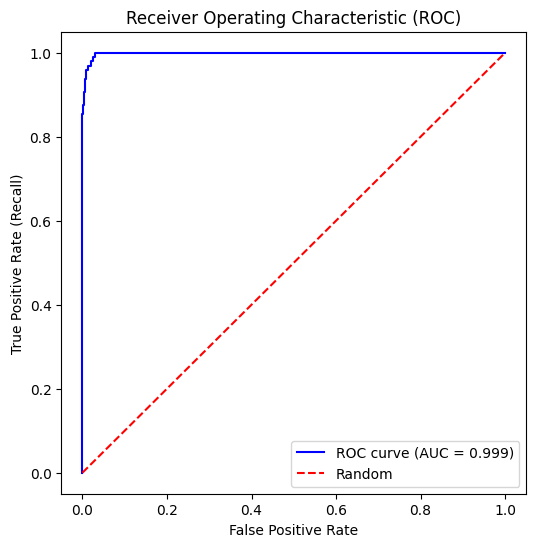

In [17]:
y_prob = best_model.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

Analisando a curva ROC notamos que o modelo tem uma performance de separação de classes muito boa, próxima do perfeito.

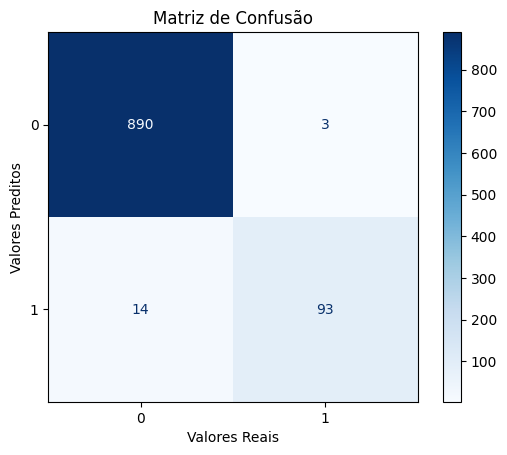

In [18]:
y_pred = best_model.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
cm_transposed = cm.T

disp = ConfusionMatrixDisplay(confusion_matrix=cm_transposed, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Matriz de Confusão")
plt.show()

Percebemos que a matriz de confusão retrata bem o porque deste modelo ter o melhor retorno da nossa função de lucro. O Valor de TP=93 e FP=14, onde o melhor cenário seria TP=107 e FP=0

### Curva de Lucro Esperado (Expected Profit Curve)

Nosso modelo gera **probabilidades de um cliente aceitar a oferta**, porém essas probabilidades **não são exatas**, ou seja, não podemos esperar que um valor de 0.8 signifique exatamente 80% de chance de aceitar. Ainda assim, essas probabilidades **mantêm uma ordem relativa**, indicando quais clientes são mais propensos a aceitar a oferta.

Para otimizar o retorno do marketing, utilizamos a **curva de lucro esperado**:

- Definimos vários **thresholds de probabilidade** entre 0 e 1.
- Para cada threshold, selecionamos os clientes cuja probabilidade de aceitar seja **maior ou igual ao threshold**.
- Calculamos o **lucro esperado**, considerando:
  - **Custo por envio da oferta** por cliente.
  - **Retorno estimado** caso o cliente aceite a oferta.
- Plotamos o **threshold no eixo x** e o **lucro esperado no eixo y**.

Dessa forma, conseguimos identificar o **threshold ótimo** = 0.68, ou seja, o ponto em que o lucro esperado é maximizado, direcionando a oferta para os clientes mais promissores.


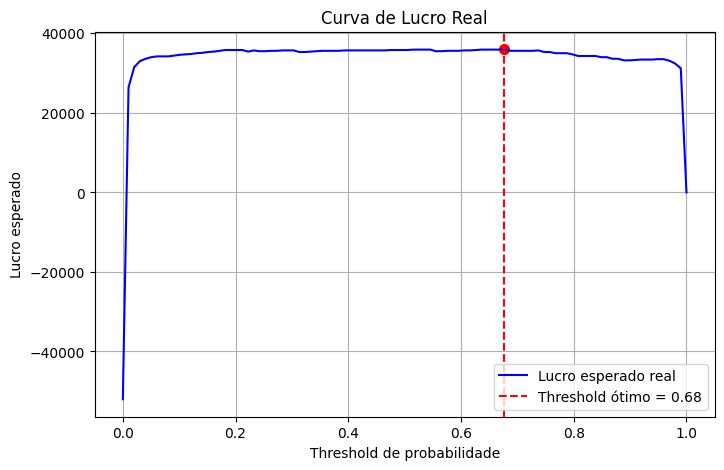

In [19]:
thresholds = np.linspace(0, 1, 100)
profits = []

for t in thresholds:
    y_pred_threshold = np.where(y_prob >= t, 1, 0)
    profit = profit_function(y_test, y_pred_threshold)
    profits.append(profit)

profits = np.array(profits)

optimal_idx = profits.argmax()
optimal_threshold = thresholds[optimal_idx]
optimal_profit = profits[optimal_idx]

plt.figure(figsize=(8,5))
plt.plot(thresholds, profits, color="blue", label="Lucro esperado real")
plt.axvline(optimal_threshold, color="red", linestyle="--", label=f"Threshold ótimo = {optimal_threshold:.2f}")
plt.scatter(optimal_threshold, optimal_profit, color="red", s=50)
plt.xlabel("Threshold de probabilidade")
plt.ylabel("Lucro esperado")
plt.title("Curva de Lucro Real")
plt.grid(True)
plt.legend()
plt.show()

### Caso Hipotético de Marketing

O banco destinou um **investimento total de $10.000** para uma campanha de marketing direcionada.  

Para cada cliente que receber a oferta:

- Existe um **custo fixo de $100** (envio da oferta, atendimento, etc.).  
- Caso o cliente aceite a oferta, o **retorno estimado é de $500**.  

O objetivo é **identificar os clientes mais propensos a aceitar a oferta** de uma base de dados de 1000 clientes, de forma a **maximizar o lucro esperado**, considerando tanto o custo do envio quanto o retorno obtido pelos clientes que aceitarem.  

**Limitação da campanha:**

- A oferta pode ser enviada para **no máximo 100 clientes**.  
- Assim, a seleção dos clientes deve priorizar aqueles com **maior probabilidade de aceitação**, garantindo o melhor retorno possível dentro do limite da campanha.


In [20]:
y_pred_threshold = np.where(y_prob >= optimal_threshold, 1, 0)

df_probs = pd.DataFrame({
    "cliente_id": x_test.index,
    "prob_accept": y_prob,
    "predict": y_pred_threshold
})

df_probs_sorted = df_probs.sort_values(by="prob_accept", ascending=False)
df_above_threshold = df_probs_sorted[df_probs_sorted["predict"] == 1]

In [21]:
max_costumers = 100
cost_per_client = 100
gain_per_client = 500

df_top_limited = df_above_threshold.head(max_costumers)

y_pred_limited = df_top_limited["predict"].values
y_true_limited = y_test.loc[df_top_limited["cliente_id"]].values

profit = profit_function(y_true_limited, y_pred_limited)

num_offers_sent = len(df_top_limited)
total_cost = num_offers_sent * cost_per_client           
gross_return = sum(y_true_limited) * gain_per_client    

print(f"Número de ofertas enviadas: {num_offers_sent}")
print(f"Custo total: ${total_cost}")
print(f"Ganho bruto: ${gross_return}")
print(f"Lucro esperado: ${profit}")


Número de ofertas enviadas: 100
Custo total: $10000
Ganho bruto: $[46000]
Lucro esperado: $36000
